# Esercizio 04.1
L'esercizio richiede di aggiungere un metodo per misurare la distribuzione delle velocità in una simulazione di dinamica molecolare basata sul modello del potenziale di Lennard-Jones e che utilizza l'algoritmo di Verlet per aggiornare la posizione delle particelle. Le particelle inizialmente partono da una configurazione spaziale ad alta entropia: sono situate su un reticolo cristallino fcc. Le velocità iniziali invece sono estratte da una distribuzione di Maxwell-Boltzmann a temperatura $T^*$ iniziale. 
I dati di input iniziali della simulazione sono:
- $T^*$ = 1.1;                  
- $N_{particelle}$ = 108;                  
- $\rho^*$ = 0.8;
- $r_{cut-off}^*$ = 2.5;
- $\delta t$ di Verlet = 0.001;
- $N_{blocchi}$ = 20;                
- $N_{steps}$ per blocco = 2000.

## Potenziale di Lennard-Jones
$$
V(r) = 4\varepsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^6 \right]
$$

## Algoritmo di Verlet
$$
\vec{r}(t + \delta t) \approx 2\vec{r}(t) - \vec{r}(t - \delta t) + \delta t^2 \, \vec{a}(t)
$$
$$
\vec{v}(t) = \frac{\vec{r}(t + \delta t) - \vec{r}(t - \delta t)}{2\delta t} + \mathcal{O}(\delta t^2) \approx \frac{\vec{r}(t + \delta t) - \vec{r}(t - \delta t)}{2\delta t}
$$

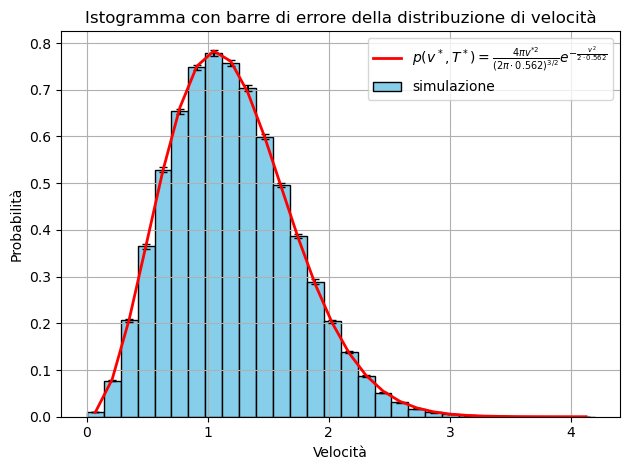

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Carico il file
data = np.loadtxt("es4.1/maxwell.dat", comments="#") #maxwell.dat contiene i dati relativi all'ultimo blocco della simulazione

# Estraggo le colonne
bin_centers = data[:, 0]
heights = data[:, 2]
errors = data[:, 3]

bin_width = data[0,0]*2  

# Creo l’istogramma con barre d’errore
plt.bar(bin_centers, heights, width=bin_width, align='center', yerr=errors, capsize=3, color='skyblue', edgecolor='black', label='simulazione')#align serve per allineamento centrale

# Parametro della temperatura in unità ridotte T
T_star = 0.561875 #preso da temperature.dat, ultima riga, è la temperatura finale del sistema

# Calcolo la distribuzione teorica di Maxwell-Boltzmann normalizzata prendendo come ascisse i centri dei bins
v = bin_centers
prefactor = 4 * np.pi * v**2 / ((2 * np.pi * T_star) ** (3/2))
exp_factor = np.exp(-v**2 / (2 * T_star))
theoretical = prefactor * exp_factor

# Plot della funzione teorica
plt.plot(v, theoretical, 'r-', linewidth=2, label=rf'$p(v^*, T^*) = \frac{{4\pi v^{{*2}}}}{{(2\pi \cdot {T_star:.3f})^{{3/2}}}} e^{{-\frac{{v^{2}}}{{2 \cdot {T_star:.3f}}}}}$')

plt.xlabel('Velocità')
plt.ylabel('Probabilità')
plt.title('Istogramma con barre di errore della distribuzione di velocità')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Analisi del grafico
Il grafico mostra l'istogramma delle velocità finali delle particelle e la distribuzione di Maxwell-Boltzmann teorica. Si nota un estremo accordo tra i dati ottenuti dalla simulazione e la distribuzione teorica, ciò significa che il sistema riproduce bene la dinamica molecolare di particelle interagenti. In particolare risulta in perfetto accordo la velocità più probabile, ovvero $v^* = \sqrt{2T^*}$.

## Commento sulla realizzazione del codice
Il codice richiede come input la larghezza dei bins, quest'ultima è stata scelta in base al numero stesso dei bins e a $v^*_{max}$, cioè la velocità entro cui ricade il $95 % $ delle velocità delle particelle secondo la distribuzione di Boltzmann. Questo parametro vale $v^*_{max}=4\sqrt{T^*}$. 

# Esercizio 04.2
L'esercizio richiede di eseguire una simulazione MD secondo il modello del potenziale di Lennard-Jones di un gas in condizioni iniziali di entropia molto bassa per verificare che il sistema evolve verso stati ad alta entropia. La configurazione iniziale ad alta entropia prevede:
- particelle situate in metà box della simulazione distribuite in un reticolo cristallino fcc;
- velocità delle singole particelle pari a $\pm v_T^* = 3\sqrt T^*$ (in modo da rispettare il legame tra energia cinetica e temperatura in termodinamica) lungo una delle 3 direzioni spaziali.

I dati di input iniziali della simulazione sono:
- $T^*$ = 2.0;                  
- $N_{particelle}$ = 108;                  
- $\rho^*$ = 0.05;
- $r_{cut-off}^*$ = 5.0;
- $\delta t$ di Verlet = 0.001;
- $N_{blocchi}$ = 20;                
- $N_{steps}$ per blocco = 2000.

## Distribuzione delle velocità

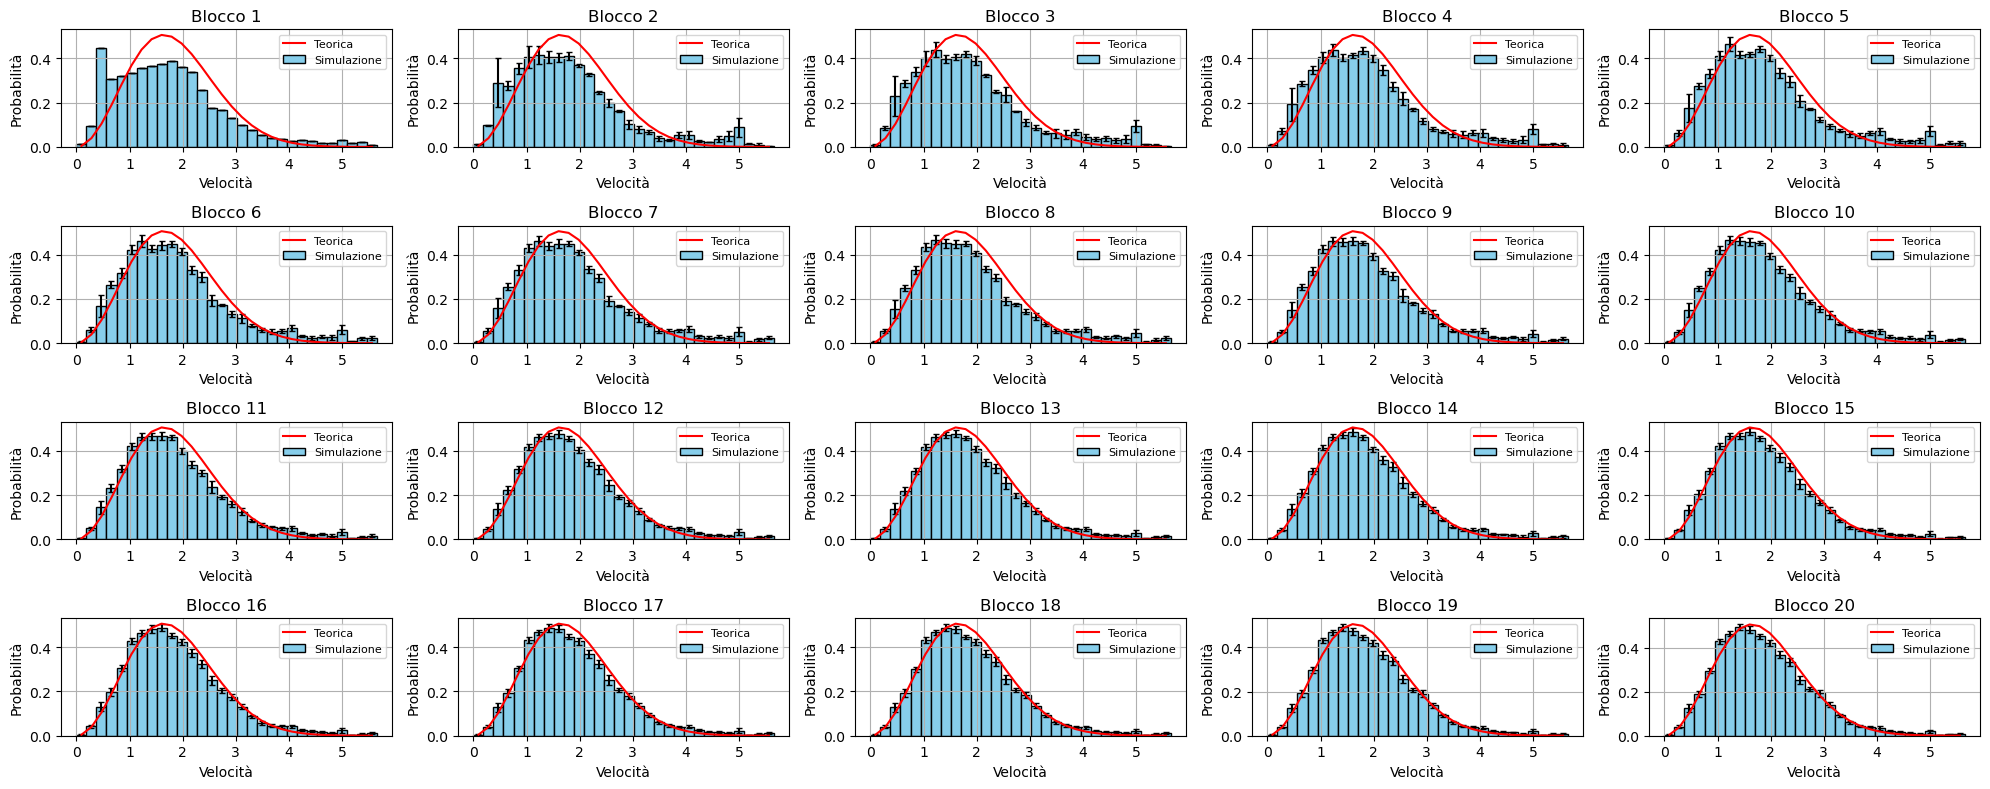

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# parametri noti
T_star = 1.34651 # temperatura usata per il fit. è stata ottenuta prendendo dati dopo un iniziale loop di termalizzazione
num_blocks = 20   # numero di blocchi in cui è suddivisa la simulazione
bins_per_block = 30  # numero di bin (intervalli di velocità) per ciascun blocco

# carico i dati dal file pofv.dat 
data = np.loadtxt("es4.2/pofv.dat", comments="#")

# larghezza del bin: il primo valore della prima riga indica il centro del primo bin,
# quindi bin_width è il doppio (per coprire tutta la larghezza del bin). è uguale per ogni bin
bin_width = data[0, 0] * 2

# definizione della distribuzione teorica di Maxwell-Boltzmann
def maxwell_boltzmann(v, T_star):
    prefactor = 4 * np.pi * v**2 / ((2 * np.pi * T_star) ** (3/2))
    return prefactor * np.exp(-v**2 / (2 * T_star))

# imposto una griglia 4x5
fig, axes = plt.subplots(4, 5, figsize=(20, 8))
axes = axes.flatten()  # per iterare facilmente

# ciclo per generare e salvare un grafico per ciascun blocco
for i in range(num_blocks):
    ax = axes[i]
    # estraggo i dati del blocco corrente (30 righe alla volta)
    block_data = data[i * bins_per_block : (i + 1) * bins_per_block]

    # prendo i centri dei bin, le altezze degli istogrammi e gli errori
    bin_centers = block_data[:, 0]  # valori centrali delle velocità
    heights = block_data[:, 2]      # frequenze (probabilità) osservate
    errors = block_data[:, 3]       # incertezze sulle frequenze

    # velocità da usare per il calcolo della curva teorica
    v = bin_centers
    theoretical = maxwell_boltzmann(v, T_star)

    # disegno nel subplot corrente
    #istogramma
    ax.bar(bin_centers, heights, width=bin_width, yerr=errors, capsize=2,
           color='skyblue', edgecolor='black', label='Simulazione')
    #funzione teorica
    ax.plot(v, theoretical, 'r-', linewidth=1.5, label='Teorica')
    ax.set_title(f'Blocco {i+1}')
    ax.set_xlabel('Velocità')
    ax.set_ylabel('Probabilità')
    ax.grid(True)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

## Energia cinetica

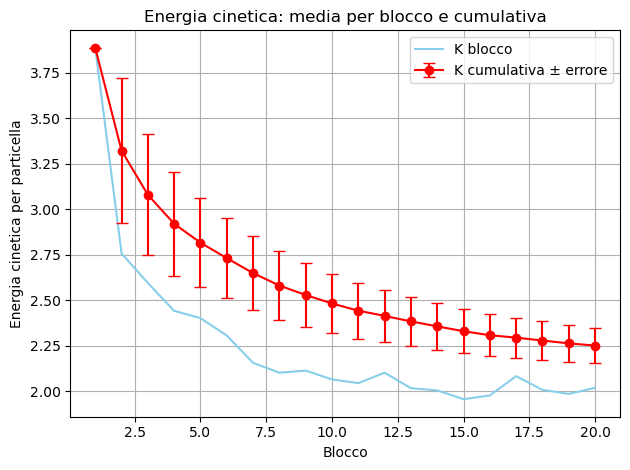

In [6]:
import numpy as np
import matplotlib.pyplot as plt

#carico i dati dell'energia cinetica
data = np.loadtxt("es4.2/kinetic_energy.dat", comments="#")
blocco = data[:,0] 
K_blocco = data[:,1] 
K_cumulativa = data[:,2] 
K_errore = data[:,3] 

# creo il grafico
plt.figure()

# energia cinetica media per blocco
plt.plot(blocco, K_blocco, label="K blocco", color='skyblue')

# media cumulativa
plt.errorbar(blocco, K_cumulativa, yerr=K_errore, color='red',fmt='o-',capsize=4, label="K cumulativa ± errore")

# etichette e titolo
plt.xlabel("Blocco")
plt.ylabel("Energia cinetica per particella")
plt.title("Energia cinetica: media per blocco e cumulativa")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Energia potenziale

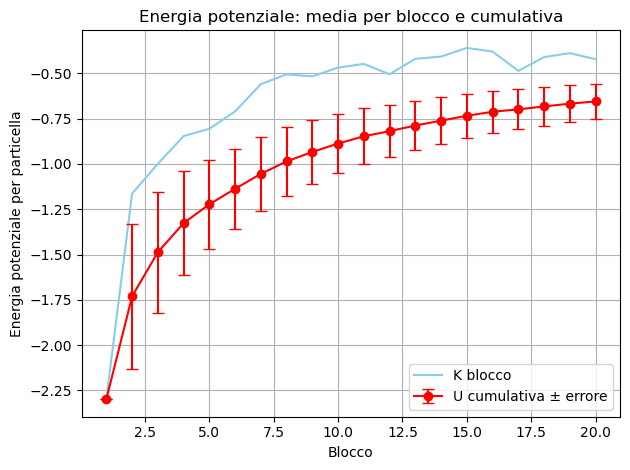

In [7]:
import numpy as np
import matplotlib.pyplot as plt

#carico i dati dell'energia potenziale
data = np.loadtxt("es4.2/potential_energy.dat", comments="#")
blocco = data[:,0] 
U_blocco = data[:,1] 
U_cumulativa = data[:,2] 
U_errore = data[:,3] 

# creo il grafico
plt.figure()

# energia potenziale media per blocco
plt.plot(blocco, U_blocco, label="K blocco", color='skyblue')

# media cumulativa
plt.errorbar(blocco, U_cumulativa, yerr=U_errore, color='red',fmt='o-',capsize=4, label="U cumulativa ± errore")

# etichette e titolo
plt.xlabel("Blocco")
plt.ylabel("Energia potenziale per particella")
plt.title("Energia potenziale: media per blocco e cumulativa")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Energia totale

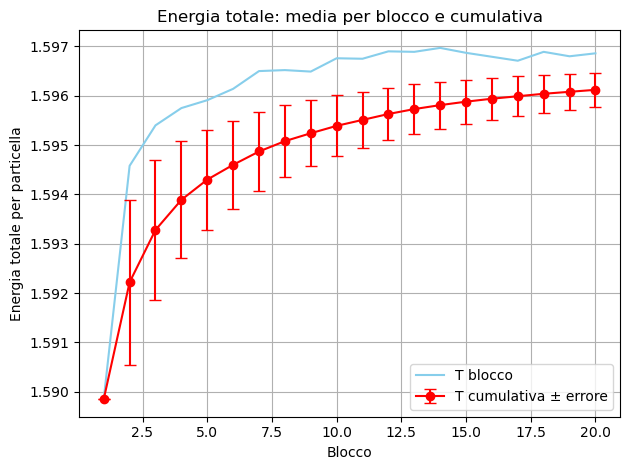

In [8]:
import numpy as np
import matplotlib.pyplot as plt

#carico i dati dell'energia totale
data = np.loadtxt("es4.2/total_energy.dat", comments="#")
blocco = data[:,0] 
T_blocco = data[:,1] 
T_cumulativa = data[:,2] 
T_errore = data[:,3] 

# creo il grafico
plt.figure()

# energia totale media per blocco
plt.plot(blocco, T_blocco, label="T blocco", color='skyblue')

# media cumulativa
plt.errorbar(blocco, T_cumulativa, yerr=T_errore, color='red',fmt='o-',capsize=4, label="T cumulativa ± errore")

# etichette e titolo
plt.xlabel("Blocco")
plt.ylabel("Energia totale per particella")
plt.title("Energia totale: media per blocco e cumulativa")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Temperatura

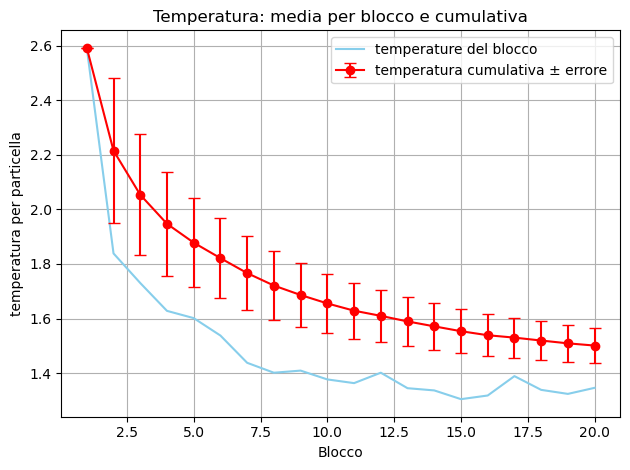

In [9]:
import numpy as np
import matplotlib.pyplot as plt

#carico i dati della temperatura
data = np.loadtxt("es4.2/temperature.dat", comments="#")
blocco = data[:,0] 
temp_blocco = data[:,1] 
temp_cumulativa = data[:,2] 
temp_errore = data[:,3] 

# creo il grafico
plt.figure()

# temperatura media per blocco
plt.plot(blocco, temp_blocco, label="temperature del blocco", color='skyblue')

# media cumulativa
plt.errorbar(blocco, temp_cumulativa, yerr=temp_errore, color='red',fmt='o-',capsize=4, label="temperatura cumulativa ± errore")

# etichette e titolo
plt.xlabel("Blocco")
plt.ylabel("temperatura per particella")
plt.title("Temperatura: media per blocco e cumulativa")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Analisi dei grafici e confronto
Come si può vedere dai grafici, in particolare quelli di temperatura ed energie, il sistema dopo un iniziale transitorio tende a un valore costante con piccole fluttuazioni. Solo l'energia totale, seppur dopo una piccola fluttuazione statistica iniziale, si può considerare conservata per tutta la simulazione essendo una quantità conservata nella dinamica del sistema in cui agiscono forze conservative. E' importante sottolineare la discrepanza tra medie di blocco e medie cumulative, con quest'ultime che sottostimano o sovrastimano le grandezze all'equilibrio. Il motivo è da ricercarsi nel fatto che le medie cumulative e anche le incertezze calcolate col data blocking risentono di **tutte** le medie di blocco, anche di quelle del transiente iniziale in cui il sistema è instabile. Ciò comporta una sottostima o una sovrastima della grandezza misurata nella simulazione. Una possibile soluzione consiste nell'iniziare a prendere i dati solo in seguito alla termalizzazione del sistema, in questo modo le medie cumulative e l'incertezza hanno un'interesse fisico e rispecchiano la realtà. In ogni caso si può affermare che 
$$
\text{Effetto del transitorio} \sim \frac{1}{N} \sum_{i=1}^{N_{\text{trans}}} A_i \longrightarrow 0 \quad \text{quando } N \gg N_{\text{trans}}
$$
Dunque le medie cumulative rispecchiano il valore fisico per $N_{blocchi}$ molto grande se prendo dati anche nel transitorio iniziale. Di conseguenza anche la distribuzione delle velocità convergerà alla distribuzione teorica di Maxwell-Boltzmann per $N$ grande; convergenza che si può intuire anche dai 20 grafici delle distribuzioni blocco per blocco. Il valore della temperatura con cui è stata plottata la distribuzione teorica (in rosso) è ottenuto raccogliendo i dati sulla temperatura dopo la termaizzazione del sistema, valore intorno a $T^* = 1.3$.

## Conclusioni
La simulazione descrive bene come evolve un sistema perchè mostra come questo, partendo da una configurazione a bassa entropia, evolva verso una configurazione ad alta entropia, esattamente come si comportano i sistemi reali. Il sistema si termalizza esattamente come si termalizzerebbe un sistema reale.
Si noti anche come la temperatura e l'energia cinetica della simulazione siano legate e coerenti con la formula termodinamica $K^* = \frac{3}{2}T^*$, infatti i valori finali di $T^*$ e $K^*$ sono $T^* \approx 1.35$ mentre $K^* \approx 2.0$.

# Esercizio 04.3
L'esercizio richiede di simulare prima il sistema con le condizioni iniziali dell'esercizio $04.2$ e di simulare poi il sistema invertendo la direzione del tempo. L'algoritmo di Verlet è time-reversible, invertendo $x_{t-\delta t}$ e $x_{t+\delta t}$ il sistema simulato con l'algoritmo di Verlet è in grado di tornare alle condizioni iniziali.

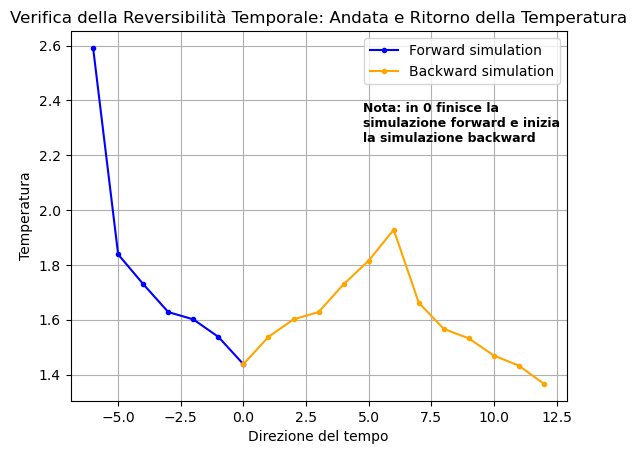

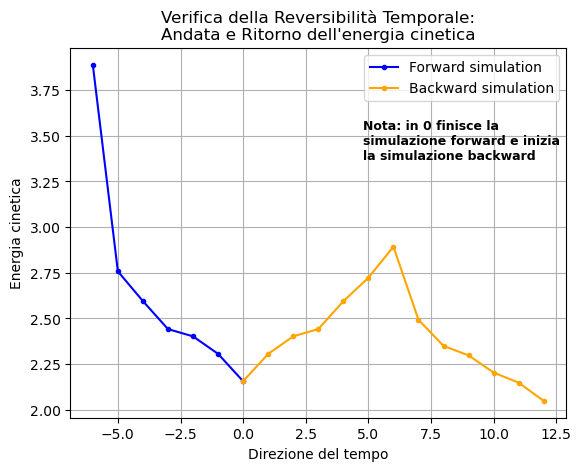

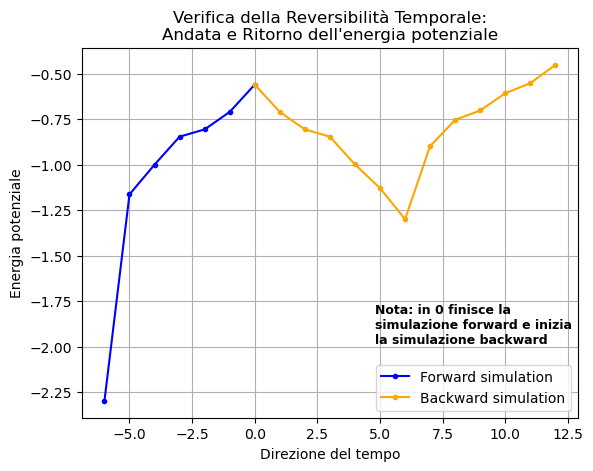

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Carica tutti i dati
dataforwardT = np.loadtxt("FORWARD_TIME/temperature.dat", comments="#")
databackwardT = np.loadtxt("es4.3/temperature.dat", comments="#")
dataforwardK = np.loadtxt("FORWARD_TIME/kinetic_energy.dat", comments="#")
databackwardK = np.loadtxt("es4.3/kinetic_energy.dat", comments="#")
dataforwardP = np.loadtxt("FORWARD_TIME/potential_energy.dat", comments="#")
databackwardP = np.loadtxt("es4.3/potential_energy.dat", comments="#")

# Dati per il forward (asse x traslato di -7)
x_forwardT = dataforwardT[:, 0] - 7
y_forwardT = dataforwardT[:, 1]

# Dati per il backward (asse x traslato di -1)
x_backwardT = databackwardT[:, 0] - 1
y_backwardT = databackwardT[:, 1]

# Plot 
plt.plot(x_forwardT, y_forwardT, label="Forward simulation", color="blue", marker='o', markersize=3)
plt.plot(x_backwardT, y_backwardT, label="Backward simulation", color="orange", marker='o', markersize=3)
plt.xlabel("Direzione del tempo")
plt.ylabel("Temperatura")
plt.title('Verifica della Reversibilità Temporale: Andata e Ritorno della Temperatura' )
plt.grid(True)
plt.text(0.59, 0.7,"Nota: in 0 finisce la \nsimulazione forward e inizia\nla simulazione backward", transform=plt.gca().transAxes, fontsize=9, fontweight='bold')#aggiungo un commento al grafico, non è una legenda
plt.legend()
plt.show()

plt.clf()

# Dati per il forward (asse x traslato di -7)
x_forwardK = dataforwardK[:, 0] - 7
y_forwardK = dataforwardK[:, 1]

# Dati per il backward (asse x traslato di -1)
x_backwardK = databackwardK[:, 0] - 1
y_backwardK = databackwardK[:, 1]

# Plot 
plt.plot(x_forwardK, y_forwardK, label="Forward simulation", color="blue", marker='o', markersize=3)
plt.plot(x_backwardK, y_backwardK, label="Backward simulation", color="orange", marker='o', markersize=3)
plt.xlabel("Direzione del tempo")
plt.ylabel("Energia cinetica")
plt.title('Verifica della Reversibilità Temporale:\nAndata e Ritorno dell\'energia cinetica' )
plt.grid(True)
plt.text(0.59, 0.7,"Nota: in 0 finisce la \nsimulazione forward e inizia\nla simulazione backward", transform=plt.gca().transAxes, fontsize=9, fontweight='bold')#aggiungo un commento al grafico, non è una legenda
plt.legend()
plt.show()

plt.clf()

# Dati per il forward (asse x traslato di -7)
x_forwardP = dataforwardP[:, 0] - 7
y_forwardP = dataforwardP[:, 1]

# Dati per il backward (asse x traslato di -1)
x_backwardP = databackwardP[:, 0] - 1
y_backwardP = databackwardP[:, 1]

# Plot 
plt.plot(x_forwardP, y_forwardP, label="Forward simulation", color="blue", marker='o', markersize=3)
plt.plot(x_backwardP, y_backwardP, label="Backward simulation", color="orange", marker='o', markersize=3)
plt.xlabel("Direzione del tempo")
plt.ylabel("Energia potenziale")
plt.title('Verifica della Reversibilità Temporale:\nAndata e Ritorno dell\'energia potenziale' )
plt.grid(True)
plt.text(0.59, 0.2,"Nota: in 0 finisce la \nsimulazione forward e inizia\nla simulazione backward", transform=plt.gca().transAxes, fontsize=9, fontweight='bold')#aggiungo un commento al grafico, non è una legenda
plt.legend()
plt.show()

## Analisi dei grafici, commenti e conclusioni
Innanzitutto si osserva che nella simulazione backward sono stati presi i dati per più blocchi (a parità di step) rispetto alla simulazione forward, questo per verificare che effettivamente il sistema non torna mai alla configurazione iniziale di bassa entropia, anzi, dopo un iniziale riordinamento, il sistema tende a una configurazione di alta entropia. Nella simulazione forward sono stati presi blocchi non fino all'equilibrio proprio per mettere in evidenza la non reversibilità di Verlet che ci si aspetta teoricamente. E' più evidente la parziale simmetria temporale se nella backward simulation non si parte da una situazione di equilibrio (come in questo caso). Inoltre i dati plottati si riferiscono alle medie di blocco non a quelle cumulative.

Ma perchè non si osserva una completa reversibilità temporale? Ci si aspetta infatti questo risultato perchè l'algoritmo di Verlet è time-reversible e le equazioni di Newton sono invarianti rispetto all'inversione temporale quando sul sistema agiscono forze conservative, come in questo caso. Il motivo dello scarto tra teoria e pratica è attribuibile principalmente agli errori di arrotondamento numerico introdotti a ogni passo temporale, che si accumulano progressivamente. Tali errori, seppur minimi localmente, si propagano esponenzialmente e impediscono al sistema di ripercorrere esattamente la traiettoria originaria quando il tempo viene invertito. Ciò dimostra che la simmetria temporale è solo parzialmente preservata in simulazioni numeriche e che, nella pratica computazionale, anche sistemi teoricamente reversibili evolvono verso stati statisticamente più probabili, cioè di maggiore entropia, evidenziando una freccia del tempo emergente.

## **Commento sulle unità ridotte**
Le grandezze misurate durante l'esecuzione delle simulazioni sono espresse in unità ridotte, indicate con il simbolo $^*$.
In questo approccio, si scelgono delle unità fondamentali arbitrarie per lunghezza, energia e massa, e tutte le altre quantità fisiche vengono espresse in funzione di queste.
Nel caso di un sistema di particelle che interagiscono tramite il potenziale di Lennard-Jones, le scelte naturali sono:
- Unità di lunghezza: $\sigma$ (distanza caratteristica in cui il potenziale è nullo);
- Unità di energia: $\varepsilon$ (profondità del pozzo del potenziale LJ);
- Unità di massa: $m$ (massa tipica delle particelle).
- 
In base a queste unità fondamentali si derivano:
- Unità di tempo: $\tau = \sigma \sqrt{m/\varepsilon}$;
- Unità di temperatura: $T^* = k_B T / \varepsilon$;
- Unità di distanza: $r^* = r / \sigma$;
- Unità di velocità: $v^* = v \sqrt{m/\varepsilon}$.

## **Commento sulle condizioni delle simulazioni**
- **r di cutoff**

Nella simulazioni è stato introdotto un raggio di cutoff $r_{\text{cut}}$, oltre il quale l'interazione tra due particelle viene trascurata. Questa approssimazione è giustificata dalla natura a corto raggio del potenziale di Lennard-Jones. L'uso di un cutoff consente una drastica riduzione del costo computazionale, evitando il calcolo di forze tra particelle distanti e accelerando le simulazioni.
- **periodic bundary conditions PBC**

Per evitare effetti di bordo legati alla presenza di una superficie, nelle simulazioni sono state adottate condizioni periodiche al contorno (Periodic Boundary Conditions, PBC). In pratica, è come se il sistema simulato è contenuto in una scatola cubica che viene replicata all'infinito in tutte le direzioni spaziali, formando un reticolo infinito.

E' come se ogni particella ha infinite "copie" (immagini) nelle celle adiacenti, ma nella simulazione si memorizzano e si aggiornano solo le coordinate delle particelle nella scatola centrale. Quando una particella esce da una faccia della scatola, rientra dalla faccia opposta, garantendo la conservazione della densità e l'assenza di bordi fisici.